In [254]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import bambi as bmb
import nba_api
import time
import datetime
import arviz as az

In [44]:
import pandas as pd
from nba_api.stats.endpoints import boxscoreadvancedv2
from nba_api.stats.endpoints import leaguegamelog
import time
from tqdm import tqdm

def get_boxscores_per_season(season_id: str):
    """
    :param season_id: str, season id of the season you want to query
    :return df_boxscores: pd.DataFrame, contains all boxscores of a season
    """
    # get the season schedule
    call_season = leaguegamelog.LeagueGameLog(season=season_id)
    season = pd.concat(call_season.get_data_frames())
    
    # get that season's game ids and setup list as storage object
    game_ids = season['GAME_ID'].unique()
    list_boxscores = list()
    
    # loop over game ids and store boxscores
    for i, game in enumerate(tqdm(game_ids)):
        call_boxscore = boxscoreadvancedv2.BoxScoreAdvancedV2(game_id=game)
        list_boxscores.append(pd.concat(call_boxscore.get_data_frames()))
        
        # take a break
        time.sleep(0.6)
    
    # concatenate to dataframe
    df_boxscores = pd.concat(list_boxscores)
    df_boxscores.rename(columns={'Unnamed: 0':'player_game_index'}, inplace=True)
    
    return df_boxscores

In [95]:
def get_schedule_per_season(season_id: str):
    """
    :param season_id: str, season id of the season you want to query
    :return df_schedule: pd.DataFrame, contains schedule of a season
    """
    # get the season schedule
    call_season = leaguegamelog.LeagueGameLog(season=season_id)
    schedule = pd.concat(call_season.get_data_frames())
    
    return schedule

In [425]:
season = "2015-16"

In [426]:
df_boxscores = get_boxscores_per_season(season_id=season)
df_boxscores.to_csv("boxscores_15_16.csv")
df_schedule = get_schedule_per_season(season_id=season)
df_schedule.to_csv("schedule_15_16.csv")

TypeError: get_boxscores_per_season() got an unexpected keyword argument 'season_id'

In [410]:
df_boxscores = pd.read_csv("boxscores_20_21.csv")

team_game_pie = df_boxscores.groupby(['GAME_ID', 'TEAM_ID'])['PIE'].agg('sum')
team_game_pie = team_game_pie.reset_index()


In [411]:
df_schedule = pd.read_csv("schedule_20_21.csv")
team_game_diff = df_schedule['PLUS_MINUS']

In [412]:
df_merge = pd.merge(team_game_pie, df_schedule, how="left")
df_merge['PIE_log'] = np.log1p(df_merge['PIE'])

/Users/hoener/opt/anaconda3/envs/ds/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [413]:
df_merge['home_game'] = df_merge['MATCHUP'].apply(lambda x: False if x.find('@') != -1 else True)
df_merge['date'] = df_merge['GAME_DATE'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
df_merge['month'] = df_merge['date'].apply(lambda x: x.month)

In [414]:
# df_merge = df_merge[(df_merge['PIE'] > -1) & (df_merge['PIE'] < 4)]
df_merge = df_merge[~df_merge['PIE_log'].isna()]
df_merge['PLUS_MINUS'] = df_merge['PLUS_MINUS']

In [394]:
df_merge

,GAME_ID,TEAM_ID,PIE,Unnamed: 0,SEASON_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_DATE,MATCHUP,WL,...,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,PIE_log,home_game,date,month
0,22000001,1610612744,1.529,1,22020,GSW,Golden State Warriors,2020-12-22,GSW @ BKN,L,...,6,18,24,99,26,1,0.927824,False,2020-12-22,12
1,22000001,1610612751,2.164,0,22020,BKN,Brooklyn Nets,2020-12-22,BKN vs. GSW,W,...,7,20,22,125,26,1,1.151837,True,2020-12-22,12
3,22000002,1610612747,1.427,3,22020,LAL,Los Angeles Lakers,2020-12-22,LAL vs. LAC,L,...,2,19,20,109,7,1,0.886656,True,2020-12-22,12
4,22000003,1610612738,1.372,4,22020,BOS,Boston Celtics,2020-12-23,BOS vs. MIL,W,...,6,7,17,122,1,1,0.863733,True,2020-12-23,12
5,22000003,1610612749,1.255,5,22020,MIL,Milwaukee Bucks,2020-12-23,MIL @ BOS,L,...,6,16,20,121,1,1,0.813150,False,2020-12-23,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,22001078,1610612759,1.711,2135,22020,SAS,San Antonio Spurs,2021-05-16,SAS vs. PHX,L,...,5,10,8,121,2,1,0.997318,True,2021-05-16,5
2156,22001079,1610612754,1.370,2154,22020,IND,Indiana Pacers,2021-05-16,IND @ TOR,W,...,3,13,19,125,12,1,0.862890,False,2021-05-16,5
2157,22001079,1610612761,0.955,2155,22020,TOR,Toronto Raptors,2021-05-16,TOR vs. IND,L,...,3,12,12,113,12,1,0.670390,True,2021-05-16,5
2158,22001080,1610612764,1.359,2152,22020,WAS,Washington Wizards,2021-05-16,WAS vs. CHA,W,...,3,14,20,115,5,1,0.858238,True,2021-05-16,5


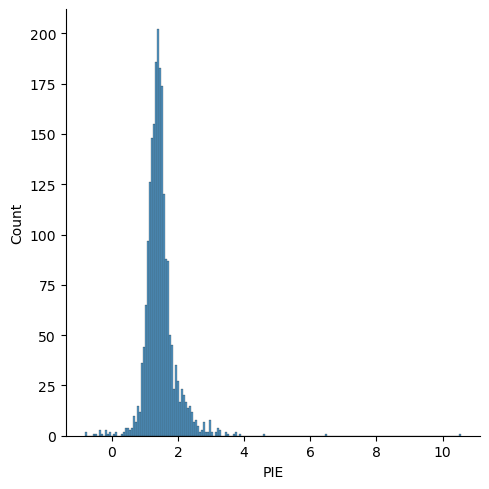

In [395]:
sns.displot(data=df_merge, x='PIE')
plt.show()

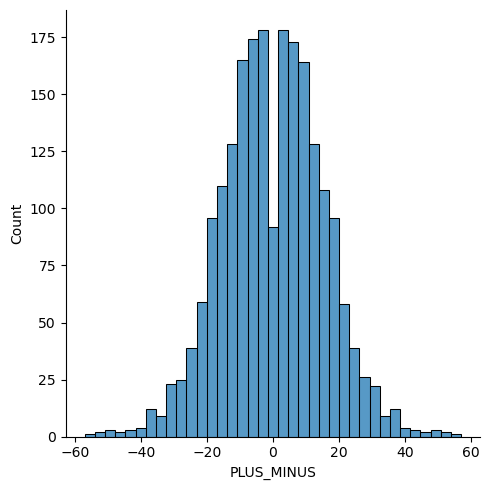

In [415]:
sns.displot(data=df_merge, x='PLUS_MINUS')
plt.show()

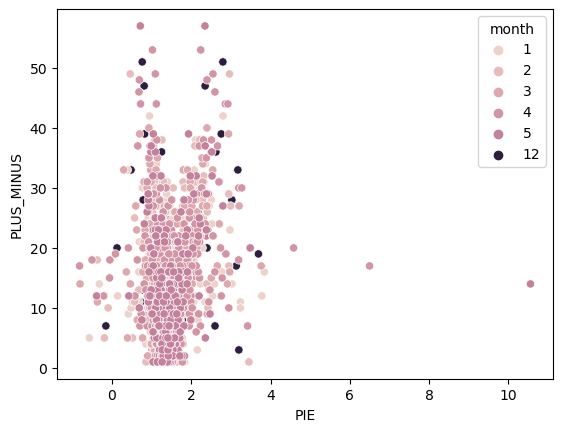

In [397]:
sns.scatterplot(data=df_merge, x='PIE', y='PLUS_MINUS', hue='month')
plt.show()

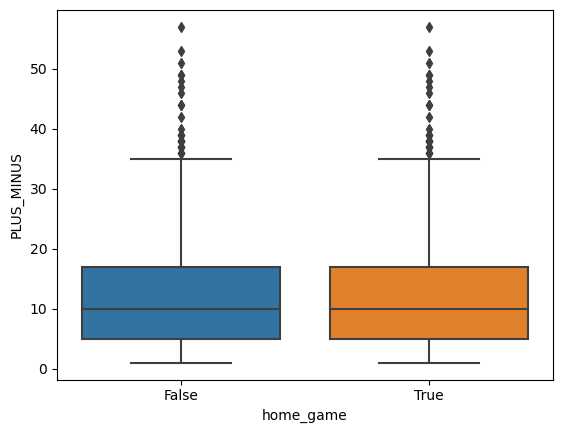

In [398]:
sns.boxplot(data=df_merge, x='home_game', y='PLUS_MINUS')
plt.show()

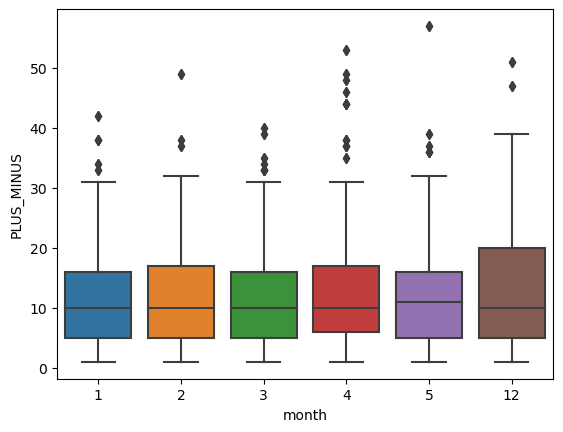

In [399]:
sns.boxplot(data=df_merge, x='month', y='PLUS_MINUS')
plt.show()

In [416]:
from pymc3 import HalfCauchy, Model, Normal, glm, plot_posterior_predictive_glm, sample

In [417]:
model = bmb.Model("PLUS_MINUS ~ PIE_log + month + home_game", df_merge)
trace = model.fit(draws=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PLUS_MINUS_sigma, Intercept, home_game, month, PIE_log]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 24 seconds.


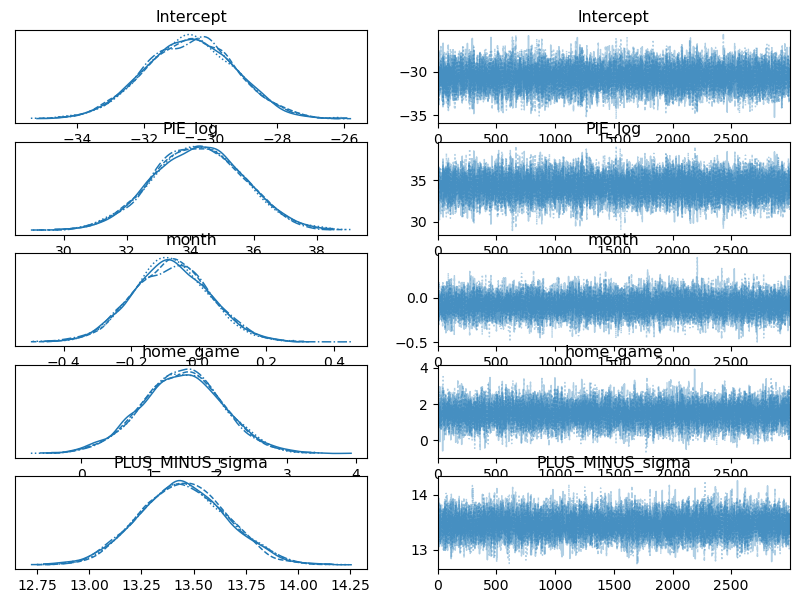

In [418]:
az.plot_trace(trace, figsize=(10, 7), compact=True)
plt.show()

In [419]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-30.615,1.358,-33.161,-28.103,0.009,0.006,22274.0,9641.0,1.0
PIE_log,34.247,1.422,31.540,36.845,0.009,0.007,22758.0,9936.0,1.0
month,-0.082,0.114,-0.297,0.129,0.001,0.001,21900.0,9547.0,1.0
home_game,1.470,0.589,0.340,2.574,0.004,0.003,21395.0,9752.0,1.0
PLUS_MINUS_sigma,13.450,0.209,13.072,13.843,0.001,0.001,20808.0,9925.0,1.0


In [420]:
model.predict(trace, data=df_merge)

In [421]:
# Compute mean across chains
posterior_mean = trace.posterior["PLUS_MINUS_mean"].values.mean(0)

# Select 1000 draws
posterior_mean = posterior_mean[:1000, :]
posterior_mean.shape

(1000, 2153)

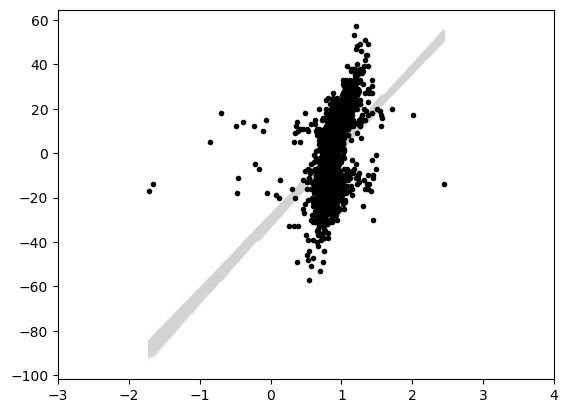

In [422]:
plt.plot(df_merge['PIE_log'], posterior_mean.T, color="lightgray", alpha=0.005)
plt.plot(df_merge['PIE_log'], df_merge['PLUS_MINUS'], '.', color="black")
plt.xlim(-3, 4)
plt.show()

In [423]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(df_merge['PIE_log'].to_numpy().reshape(-1,1), df_merge['PLUS_MINUS'].to_numpy().reshape(-1,1))
pred = reg.predict(df_merge['PIE_log'].to_numpy().reshape(-1,1))

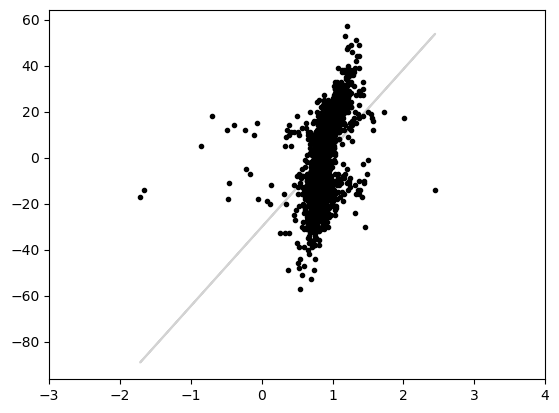

In [424]:
plt.plot(df_merge['PIE_log'], pred, color="lightgray")
plt.plot(df_merge['PIE_log'], df_merge['PLUS_MINUS'], '.', color="black")
plt.xlim(-3, 4)
plt.show()